In [1]:
using Revise, Pkg
Pkg.activate("/home/louise/MSA/BpAlignGpu.jl")
using BpAlignGpu

  Activating project at `~/MSA/BpAlignGpu.jl`


In [2]:
using CUDA
CUDA.device!(1)

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA /home/louise/.julia/packages/CUDA/bki2w/src/initialization.jl:70


CuDevice(1): TITAN RTX

In [3]:
T = Float32

Float32

In [4]:
#### USING SAME DATA AS DCAlign-master

### PF00684 data ##
open("/home/louise/MSA/Data/test/PF00684/")
q = 21; L = 67; 
ctype=Symbol("amino")
typel=Symbol("bm")

J, H = BpAlignGpu.read_parameters("/home/louise/MSA/Data/test/PF00684/Parameters_bm_PF00684seed_potts.dat", q, L, gap=0, typel=typel);

### PF00684 sequences ##

delta = 50;
al = BpAlignGpu.enveloptoalign( "/home/louise/MSA/Data/test/PF00684/Test_PF00684.full", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.fasta", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.ins", delta = delta, ctype = ctype);
M = length(al)

using DelimitedFiles
Lambda_all = readdlm("/home/louise/MSA/Data/test/PF00684/Lambda_PF00684.dat")
lambda_o = Lambda_all[:,1];
lambda_e = Lambda_all[:,2];


┌ Info: Assuming J i j a b and h i a format
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:37
┌ Info: Output tersors: J[a b i j] and h[a i]
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:39
┌ Info: Gap in input file 0 now in 21
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:40


In [4]:
open("/home/louise/MSA/Data/test/PF00397/")
q = 21; L = 31; 
ctype=Symbol("amino")
typel=Symbol("bm")

J, H = BpAlignGpu.read_parameters("/home/louise/MSA/Data/test/PF00397/Parameters_plm_PF00397.dat", q, L, gap=0, typel=typel);

delta = 5;
al = BpAlignGpu.enveloptoalign( "/home/louise/MSA/Data/test/PF00397/PF00397_full_length_sequences.fasta", "/home/louise/MSA/Data/test/PF00397/PF00397_full.fasta", "/home/louise/MSA/Data/test/PF00397/PF00397_full.inse", delta = delta, ctype = ctype);
M = length(al)

using DelimitedFiles
Lambda_all = readdlm("/home/louise/MSA/Data/test/PF00397/Lambda_PF00397.dat")
lambda_o = Lambda_all[1,:];
lambda_e = Lambda_all[2,:];


┌ Info: Assuming J i j a b and h i a format
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:37
┌ Info: Output tersors: J[a b i j] and h[a i]
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:39
┌ Info: Gap in input file 0 now in 21
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:40


In [5]:
muext = 0.00;
muint = 2.50;

In [100]:

println("Consider this sequence: ")
# consider one random sequence as an example
idx0 = 10#52# rand(1:M) 
(aux,garb) = split(al[idx0][1], "/")
seqsol = al[idx0][3];
seqins = al[idx0][4];
seq = BpAlignGpu.Seq(seqsol, al[idx0][2], ctype)
N = length(al[idx0][2])
println(al[idx0][1])
println("Full length: ")
println(al[idx0][2])
println("Aligned by HMMer (without and with insertions): ")
println(seqsol)
println(seqins)



Consider this sequence: 
A0A2K5LVX8_CERAT/130-169
Full length: 
AELLLSQCPWKEYKSDTGKPYYYNNQSKESRWTRPKDLDD
Aligned by HMMer (without and with insertions): 
--CPWKEYKSDT-GKPYYYNNQSKESRWTRP
--CPWKEYKSDT-GKPYYYNNQSKESRWTRP


In [101]:
q, N, L

(21, 40, 31)

In [102]:
pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)

ParamModel{Float32}[L=31 N=40 q=21 size=1.619 MiB]

In [112]:
damp=T(0.1)
tol=T(1e-9)
tolnorm=T(1e-5)
tmax=10
upscheme=:sequential # :random or :sequential
lr=:sce  # :sce or :mf or :sr
beta=T(2.0)
verbose=true
pa = ParamAlgo(damp, tol, tolnorm, tmax, upscheme, lr, beta, verbose)

ParamAlgo{Float32}
-------------
damp=0.1
tol=1.0e-9
tolnorm=1.0e-5
tmax=10
upscheme=sequential
lr=sce
beta=2.0
verbose=true
-------------

In [113]:
bpm = BPMessages(seq, pm)
bpb = BPBeliefs(N, L)
lrf = LongRangeFields(N, L)
af = AllFields(bpm, bpb, lrf)

AllFields{Float32}[L=31 N=40 ongpu=true size=53.492 MiB]

In [114]:
@time BpAlignGpu.update_F!(af, pm, pa)

  0.001383 seconds (726 allocations: 45.547 KiB)


In [115]:
@time BpAlignGpu.update_hF!(af, pm, pa)
@time BpAlignGpu.update_B!(af, pm, pa)
@time BpAlignGpu.update_hB!(af, pm, pa)

  0.001380 seconds (750 allocations: 46.797 KiB)
  0.001376 seconds (727 allocations: 46.000 KiB)
  0.001375 seconds (796 allocations: 49.859 KiB)


In [116]:
@time BpAlignGpu.update_beliefs!(af, pm, pa)
@time BpAlignGpu.update_jointchain!(af, pm, pa)
@time BpAlignGpu.update_conditional_chain!(af, pa)
@time BpAlignGpu.update_conditional_all!(af, pm)

  0.000740 seconds (365 allocations: 23.609 KiB)
  0.000852 seconds (438 allocations: 32.047 KiB)
  0.000351 seconds (336 allocations: 19.438 KiB)
  0.050338 seconds (39.15 k allocations: 2.164 MiB)


In [117]:
@time BpAlignGpu.update_g!(af);

  0.010282 seconds (3.22 k allocations: 152.141 KiB)


In [118]:
@time BpAlignGpu.update_f!(af);

  0.009152 seconds (470 allocations: 23.672 KiB)


In [119]:
@time BpAlignGpu.test_sweep!(1,af,pm,pa)

t=1	 err=0.37293348
  0.072424 seconds (47.26 k allocations: 2.610 MiB)


In [120]:
@time BpAlignGpu.test_sweep!(50,af,pm,pa)

t=1	 err=0.863615
t=2	 err=0.9923167
t=3	 err=0.99999946
t=4	 err=0.99999946
t=5	 err=0.99985987
t=6	 err=0.9999987
t=7	 err=1.0
t=8	 err=0.4161529
t=9	 err=1.0
t=10	 err=0.99994606
t=11	 err=0.99999994
t=12	 err=1.0
t=13	 err=1.0
t=14	 err=1.0
t=15	 err=0.004492999
t=16	 err=0.0029242635
t=17	 err=0.0025892258
t=18	 err=0.0026234388
t=19	 err=0.2042563
t=20	 err=0.19759035
t=21	 err=0.005459522
t=22	 err=0.002873063
t=23	 err=0.0028594136
t=24	 err=0.0026076436
t=25	 err=0.0026189089
t=26	 err=0.002655387
t=27	 err=0.0026322007
t=28	 err=0.0026280284
t=29	 err=0.0026367307
t=30	 err=0.0026331544
t=31	 err=0.0026410818
t=32	 err=0.0026358962
t=33	 err=0.0026320815
t=34	 err=0.0026544333
t=35	 err=0.002639234
t=36	 err=0.0026270747
t=37	 err=0.0026373267
t=38	 err=0.0026330352
t=39	 err=0.0026415586
t=40	 err=0.0026356578
t=41	 err=0.0026320815
t=42	 err=0.0026544333
t=43	 err=0.0026392937
t=44	 err=0.0026271343
t=45	 err=0.0026373267
t=46	 err=0.0026330352
t=47	 err=0.0026415586
t=48	 

In [121]:
findall(isinf.(af.bpb.beliefs)), findall(isnan.(af.bpb.beliefs))

(CartesianIndex{3}[], CartesianIndex{3}[])

In [122]:
findall(isinf.(af.bpb.joint_chain)), findall(isnan.(af.bpb.joint_chain))

(CartesianIndex{5}[], CartesianIndex{5}[])

In [123]:
xnsol, maxbel = BpAlignGpu.solmaxbel(af)
seqpa, seqpo, deb, fin = BpAlignGpu.convert_soltosequence!(xnsol, seq.strseq, N, L)

("SQCPWKEYKSDT-GKPYYYNNQSKESRWTRP", "SQCPWKEYKSDT-GKPYYYNNQSKESRWTRP", 6, 35)

In [124]:
logzi = BpAlignGpu.logZi(af, pm, pa)/L

-9.369669f0

In [125]:
logZa  = BpAlignGpu.logZa(af, pm, pa)/L

12.411382f0

In [126]:
logZia = BpAlignGpu.logZia(af, pm)/L

-2.4478445f0

In [127]:
lr_free = BpAlignGpu.lr_freeen(af, pm)/L

0.8497261923433642

In [128]:
BpAlignGpu.compute_cost_function(pm.J, pm.H, seqpo, L, ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)

(onesite, couplings) = (-4.380274021998048, -59.970025042188354)
(gapcost, inscost) = (2.5f0, 0.0)


-61.85031f0

In [129]:
check = BpAlignGpu.check_sr!(xnsol, L, N)
finderrors, errL = findall(x->x==1, check), check[L]

(Int64[], 0)

In [130]:
for i in finderrors
    @show i
    println(xnsol[i-1], ", ", xnsol[i])
end

In [131]:
using Plots
bel=Array(af.bpb.beliefs);

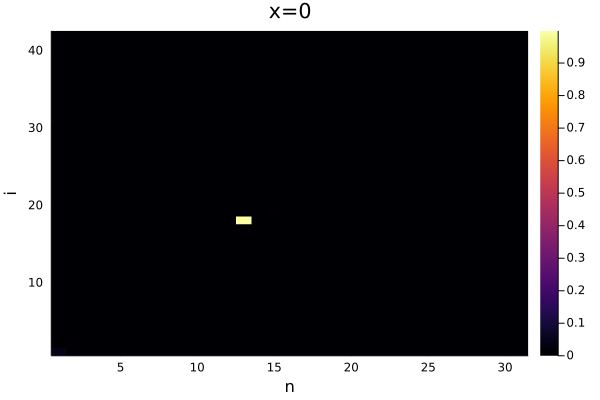

In [132]:
p0 = heatmap(bel[:,1,:], xlabel="n", ylabel="i", title="x=0")

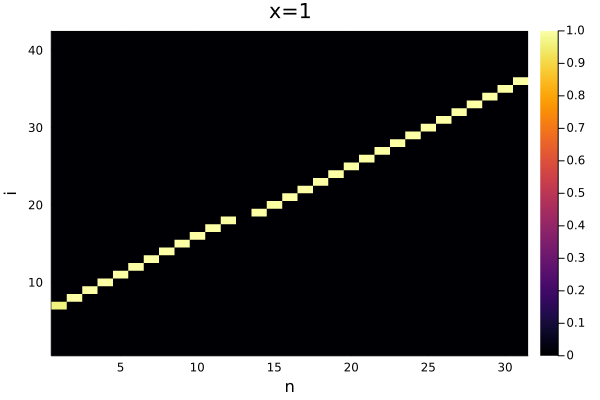

In [133]:
p1 = heatmap(bel[:,2,:], xlabel="n", ylabel="i", title="x=1")

(xnsol[i], maxbel[i]) = ((1, 24), 1.0f0)


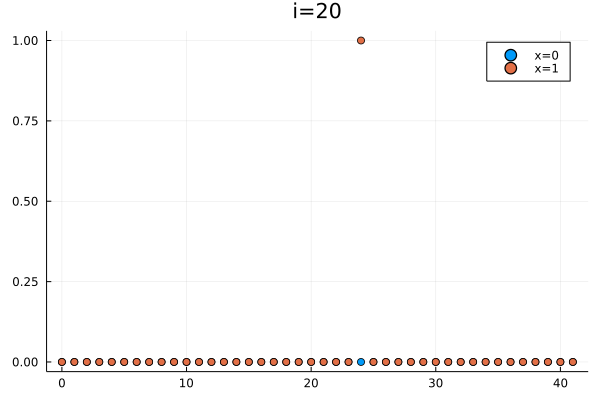

In [134]:
i=20
@show xnsol[i], maxbel[i]
scatter(0:N+1, bel[:,1,i], label="x=0", title="i=$i")
scatter!(0:N+1, bel[:,2,i], label="x=1")

In [62]:
using OffsetArrays
P = fill(fill(0.0, 0:1,0:N+1), L)
for i=1:L
    P[i] = OffsetArray(transpose(af.bpb.beliefs[:,:,i]), 0:1,0:N+1)
end
BpAlignGpu.convert_soltosequence!(xnsol, seq.strseq, N, L) == BpAlignGpu.decodeposterior(P, seq.strseq)

true

In [63]:
BpAlignGpu.check_assignment(P,true,N)

Let us check the assignment...
- 23 → (0, 0) 23-1 → (1, 95)
- 22 → (1, 95) 22-1 → (1, 108)
There are 2 short-range constraints not satisfied


false